In [1]:
import numpy as np
import matplotlib.pyplot as plt
from rlxutils import subplots
import pandas as pd
import sys
sys.path.append("..")
from lib import data
from lib import sar
from lib import io
from lib import trainer_C
from sklearn.ensemble import RandomForestRegressor
from progressbar import progressbar as pbar

In [2]:
base_path = "/home/alberto/data/data/RST2/Barcelona"
#date_train = '20100520'
#date_test  = '20120720'

date_test = '20100520'
date_train  = '20120720'

window_size = 7

In [3]:
smtr = io.load_bcn_scatter_matrix(base_path, date_train)
smts = io.load_bcn_scatter_matrix(base_path, date_test)

In [4]:
cmtr = sar.avgpool2D_complex(sar.compute_coherence_matrix(smtr), window_size = window_size)
cmts = sar.avgpool2D_complex(sar.compute_coherence_matrix(smts), window_size = window_size)

In [5]:
smtr.shape, cmtr.shape

((4402, 1602, 2, 2), (628, 228, 3, 3))

## define train/test/val split mask

may use spatial split to attempt to avoid spatial leakage between train, test, val

In [6]:
h, w, _, _ = cmtr.shape

splitmask_random = data.cv_splitpixels_random(h, w, train_pct = .70, test_pct = .15, val_pct = .15)
splitmask_bands  = data.cv_splitpixels_spatial(h, w, pixels_train = 70, pixels_test = 15, pixels_val = 15, angle = np.pi/4)

TRAIN, TEST, VAL = 0,1,2

In [7]:
cmtr_VV_ampl = (cmtr[:,:,2,2]).real
cmts_VV_ampl = (cmts[:,:,2,2]).real

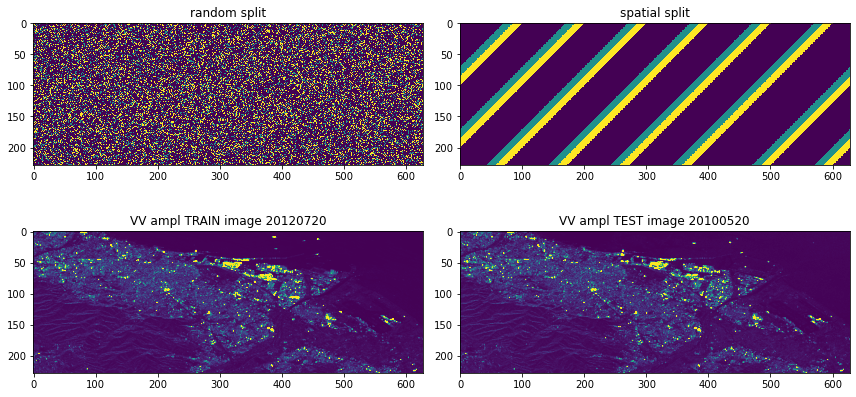

In [8]:
a,b = np.percentile(list(cmtr_VV_ampl.flatten()) + list(cmts_VV_ampl.flatten()), [1,99])

for ax, i in subplots(4, usizex=6, n_cols=2):
    if i==0: plt.imshow(splitmask_random.T, interpolation='none'); plt.title("random split")
    if i==1: plt.imshow(splitmask_bands.T, interpolation='none'); plt.title("spatial split")
    if i==2: plt.imshow(cmtr_VV_ampl.T, vmin=a, vmax=b); plt.title(f"VV ampl TRAIN image {date_train}") 
    if i==3: plt.imshow(cmts_VV_ampl.T, vmin=a, vmax=b); plt.title(f"VV ampl TEST image {date_test}") 

# Train random forest - Matrix Log parameters

**input**: $\mathbf{L}_{11}$, $\mathbf{L}_{22}$, $Re(\mathbf{L}_{12})$ and $Im(\mathbf{L}_{12})$ from the matrix logarithm of the 2 by 2 subcovariance matrix corresponding to HV and VV polarizations $\mathbf{L} = \log \mathbf{C}_{22 - 33}$ (4 values) 

**output**: $\mathbf{L}_{11} $, real part (imag is zero) from the matrix logarithm of the 3 by 3 full-pol covariance matrix $\mathbf{L} = \log \mathbf{C}$

**Note**: Since the matrix logarithm depends on the whole covariance matrix, it is not the same to perform the logarithm of the 3x3 covariance matrix and take the 2x2 submatrix than doing the logarithm of the 2x2 submatrix

In [9]:
lcmtr = sar.matlog(cmtr)
lcmts = sar.matlog(cmts)
lcmtr2 = sar.matlog(cmtr[...,1:3, 1:3])
lcmts2 = sar.matlog(cmts[...,1:3, 1:3])
lcmtr.shape, lcmtr2.shape

((628, 228, 3, 3), (628, 228, 2, 2))

In [10]:
lcmtr_VV_ampl = (lcmtr[:,:,2,2]).real
lcmts_VV_ampl = (lcmts[:,:,2,2]).real

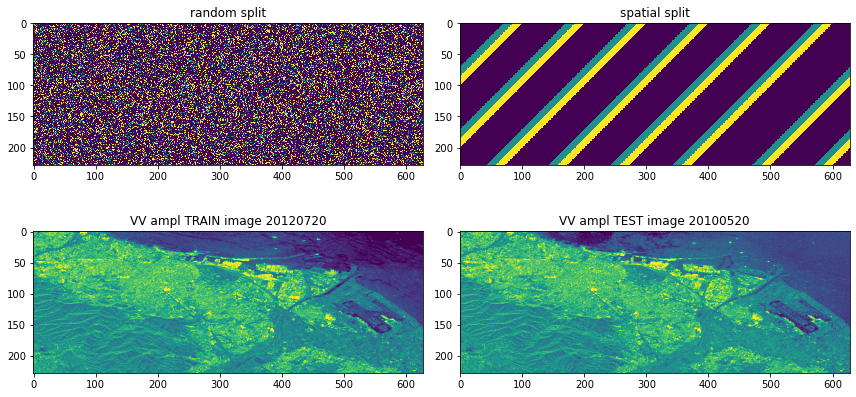

In [11]:
a,b = np.percentile(list(lcmtr_VV_ampl.flatten()) + list(lcmts_VV_ampl.flatten()), [1,99])

for ax, i in subplots(4, usizex=6, n_cols=2):
    if i==0: plt.imshow(splitmask_random.T, interpolation='none'); plt.title("random split")
    if i==1: plt.imshow(splitmask_bands.T, interpolation='none'); plt.title("spatial split")
    if i==2: plt.imshow(lcmtr_VV_ampl.T, vmin=a, vmax=b); plt.title(f"VV ampl TRAIN image {date_train}") 
    if i==3: plt.imshow(lcmts_VV_ampl.T, vmin=a, vmax=b); plt.title(f"VV ampl TEST image {date_test}") 

In order to predict the original 3x3 hermitian covariance matrix in the log space 9 elements have to be predicted:
 * the 3 elements (real) of the diagonal
 * the 3 elements of the off-diagonal (complex: real + imag)

**NOTE**: As stated before, although we have a 2x2 input matrix after the matrix logarithm, the elements of the original 3x3 covariance matrix will be different since they depend on the whole covariance matrix, therefore all the elements need to be predicted.
It is worth noticing, however, that although they are not the same, they should be *similar*

In [12]:
components2predict = [[(0,0), "real"],
                      [(0,1), "real"],
                      [(0,1), "imag"],
                      [(0,2), "real"],
                      [(0,2), "imag"],
                      [(1,1), "real"],
                      [(1,2), "real"],
                      [(1,2), "imag"],
                      [(2,2), "real"],
                      ]

100% (9 of 9) |##########################| Elapsed Time: 0:00:37 Time:  0:00:370:04


<Figure size 432x288 with 0 Axes>

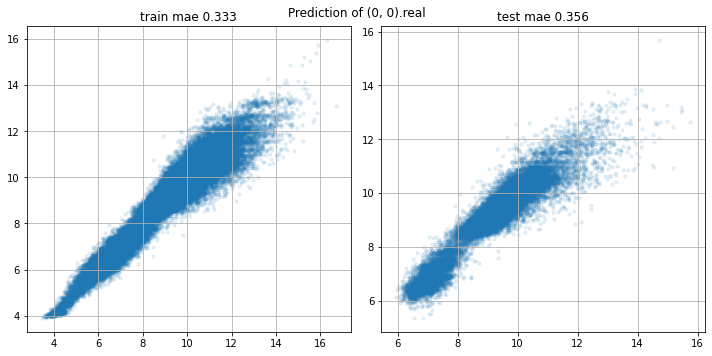

<Figure size 432x288 with 0 Axes>

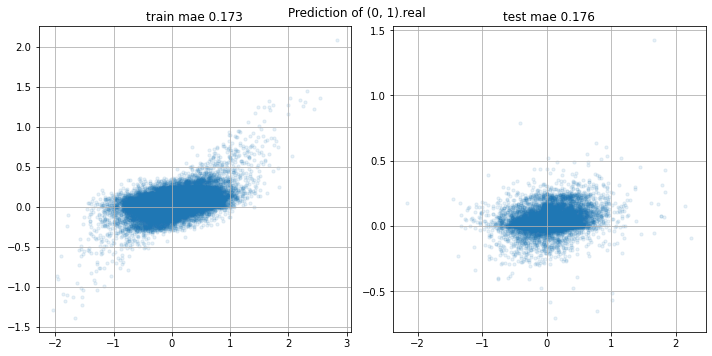

<Figure size 432x288 with 0 Axes>

In [ ]:
splitmask = splitmask_bands
#splitmask = splitmask_random
#t = trainer_C.Trainer_C(lcmtr, lcmts, lcmtr, lcmts, splitmask, [(1,1), (1,2), (2,2)], (0,0)).split()

pred_tr = []
pred_ts = []
trainers = []

for pos, comp in pbar(components2predict):
    t = trainer_C.Trainer_C(lcmtr2, lcmts2, lcmtr, lcmts, splitmask, [(0,0), (0,1), (1,1)],
                            pos, comp_to_predict=comp).split()
    t.set_estimator(RandomForestRegressor(max_depth=10, n_estimators=100, n_jobs=8))
    t.fit()
    plt.figure()
    t.plot_predictions()
    plt.suptitle(f"Prediction of {pos}.{comp}")
    pred_tr.append(t.predstr)
    pred_ts.append(t.predsts)
    trainers.append(t)

pred_tr = np.asarray(pred_tr)
pred_ts = np.asarray(pred_ts)

### Checking full matrix reconstrucion

In [ ]:
# TODO
reccmtr = np.zeros((pred_tr[0].shape[0], 3, 3), dtype=np.complex64)
reccmts = np.zeros((pred_ts[0].shape[0], 3, 3), dtype=np.complex64)

reccmtr[..., 0, 0] = pred_tr[0]
reccmtr[..., 0, 1] = pred_tr[1] + 1j*pred_tr[2]
reccmtr[..., 0, 2] = pred_tr[3] + 1j*pred_tr[4]
reccmtr[..., 1, 1] = pred_tr[5]
reccmtr[..., 1, 2] = pred_tr[6] + 1j*pred_tr[7]
reccmtr[..., 2, 2] = pred_tr[8]
reccmtr[..., 1, 0] = reccmtr[..., 0, 1].conj()
reccmtr[..., 2, 0] = reccmtr[..., 0, 2].conj()
reccmtr[..., 2, 1] = reccmtr[..., 1, 2].conj()

reccmtr = sar.matexp(reccmtr)


In [ ]:
np.all(np.linalg.eigvalsh(reccmtr) > 0)

In [ ]:
plt.scatter(10*np.log10(cmtr[splitmask==TRAIN][...,0,0].real),
           10*np.log10(reccmtr[...,0,0].real),
           alpha=.1, s=10)
plt.title("Scatter plot HH [dB]")

In [ ]:
plt.scatter(10*np.log10(np.einsum("...ii->...", cmtr[splitmask==TRAIN]).real),
           10*np.log10(np.einsum("...ii->...", reccmtr).real),
           alpha=.1, s=10)
plt.title("Scatter plot trace [dB]")

## Make full image prediction and analysis

Here the complete validation image (dual-pol) will be used to predict the full-pol data and compare the results visually

In [ ]:
log_C2_img = lcmts2
orig_C3 = cmts

x=[]
x.append(log_C2_img[:,:,0,0].real.flatten())
x.append(log_C2_img[:,:,0,1].real.flatten())
x.append(log_C2_img[:,:,0,1].imag.flatten())
x.append(log_C2_img[:,:,1,1].real.flatten())
x = np.r_[x].T


In [ ]:
reccm = np.zeros_like(orig_C3).reshape(-1,3,3)

reccm[..., 0, 0] = trainers[0].estimator.predict(x)
reccm[..., 0, 1] = trainers[1].estimator.predict(x) + 1j*trainers[2].estimator.predict(x)
reccm[..., 0, 2] = trainers[3].estimator.predict(x) + 1j*trainers[4].estimator.predict(x)
reccm[..., 1, 1] = trainers[5].estimator.predict(x)
reccm[..., 1, 2] = trainers[6].estimator.predict(x) + 1j*trainers[7].estimator.predict(x)
reccm[..., 2, 2] = trainers[8].estimator.predict(x)
reccm[..., 1, 0] = reccm[..., 0, 1].conj()
reccm[..., 2, 0] = reccm[..., 0, 2].conj()
reccm[..., 2, 1] = reccm[..., 1, 2].conj()

reccm = reccm.reshape(orig_C3.shape)
reccm = sar.matexp(reccm)


In [ ]:
# Generate normalized covariance matrices to inspect rhos
orig_dis = 1/np.sqrt(np.einsum("...ii->...i", orig_C3.real))
orig_C3_norm = np.einsum("...i,...j->...ij", orig_dis, orig_dis) * orig_C3

rec_dis = 1/np.sqrt(np.einsum("...ii->...i", reccm.real))
rec_C3_norm = np.einsum("...i,...j->...ij", rec_dis, rec_dis) * reccm


In [ ]:
plt.figure(figsize=(6,6))
plt.scatter(np.abs(orig_C3_norm[...,0,1].ravel()),
           np.abs(rec_C3_norm[...,0,1].ravel()),
           alpha=.1, s=10)
plt.xlabel("Real")
plt.ylabel("Predicted")
plt.title(r"Scatter plot $\rho_{12}$")
plt.tight_layout()

plt.figure(figsize=(6,6))
plt.scatter(np.abs(orig_C3_norm[...,0,2].ravel()),
           np.abs(rec_C3_norm[...,0,2].ravel()),
           alpha=.1, s=10)
plt.xlabel("Real")
plt.ylabel("Predicted")
plt.title(r"Scatter plot $\rho_{13}$")
plt.tight_layout()

plt.figure(figsize=(6,6))
plt.scatter(np.abs(orig_C3_norm[...,1,2].ravel()),
           np.abs(rec_C3_norm[...,1,2].ravel()),
           alpha=.1, s=10)
plt.xlabel("Real")
plt.ylabel("Predicted")
plt.title(r"Scatter plot $\rho_{23}$")
plt.tight_layout()

The $\rho_{12}$ and $\rho_{13}$ are the correlation coefficients not present on the input data.

The $\rho_{23}$ information is present on the input 2x2 covariance matrix but, due to matrix log transformation, the element on the 3x3 log matrix is not exactly the same. However, since this information is present on the input data, the prediction results are much better.

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8,10))
#fig.suptitle('H/alpha unsupervised classification')
ax1.imshow(sar.generate_Pauli_RGB_from_T(sar.get_T_from_C(orig_C3)))
ax1.set_title('Pauli RGB Original')
im = ax2.imshow(sar.generate_Pauli_RGB_from_T(sar.get_T_from_C(reccm)))
ax2.set_title('Pauli RGB Reconstructed')
plt.tight_layout()


In [ ]:
# Zoom urban area
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8,8))
#fig.suptitle('H/alpha unsupervised classification')
ax1.imshow(sar.generate_Pauli_RGB_from_T(sar.get_T_from_C(orig_C3[200:300, 50:150])))
ax1.set_title('Pauli RGB Original')
im = ax2.imshow(sar.generate_Pauli_RGB_from_T(sar.get_T_from_C(reccm[200:300, 50:150])))
ax2.set_title('Pauli RGB Reconstructed')
plt.tight_layout()


In [ ]:
# Zoom agricultural fields area
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8,8))
#fig.suptitle('H/alpha unsupervised classification')
ax1.imshow(sar.generate_Pauli_RGB_from_T(sar.get_T_from_C(orig_C3[400:500, 100:200])))
ax1.set_title('Pauli RGB Original')
im = ax2.imshow(sar.generate_Pauli_RGB_from_T(sar.get_T_from_C(reccm[400:500, 100:200])))
ax2.set_title('Pauli RGB Reconstructed')
plt.tight_layout()


In [ ]:
H, A, alpha = sar.get_H_A_alpha(sar.get_T_from_C(orig_C3))
Hr, Ar, alphar = sar.get_H_A_alpha(sar.get_T_from_C(reccm))



In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8,10))
#fig.suptitle('H/alpha unsupervised classification')
ax1.imshow(H, cmap='jet', vmin=0, vmax=1)
ax1.set_title('Entropy Original')
im = ax2.imshow(Hr, cmap='jet', vmin=0, vmax=1)
ax2.set_title('Entropy Reconstructed')
plt.tight_layout()

plt.figure(figsize=(6,6))
plt.scatter(H.ravel(), Hr.ravel(),
           alpha=.1, s=10)
plt.xlabel("Real Entropy")
plt.ylabel("Predicted Entropy")
plt.title("Scatter plot H")
plt.tight_layout()

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8,10))
#fig.suptitle('H/alpha unsupervised classification')
ax1.imshow(A, cmap='jet', vmin=0, vmax=1)
ax1.set_title('Anistropy Original')
im = ax2.imshow(Ar, cmap='jet', vmin=0, vmax=1)
ax2.set_title('Anistropy Reconstructed')
plt.tight_layout()

plt.figure(figsize=(6,6))
plt.scatter(A.ravel(), Ar.ravel(),
           alpha=.1, s=10)
plt.xlabel("Real Anisotropy")
plt.ylabel("Predicted Anisotropy")
plt.title("Scatter plot A")
plt.tight_layout()

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8,10))
#fig.suptitle('H/alpha unsupervised classification')
ax1.imshow(alpha/np.pi*180, cmap='jet', vmin=0, vmax=90)
ax1.set_title('Mean alpha angle Original')
im = ax2.imshow(alphar/np.pi*180, cmap='jet', vmin=0, vmax=90)
ax2.set_title('Mean alpha angle Reconstructed')

plt.tight_layout()

plt.figure(figsize=(6,6))
plt.scatter(alpha.ravel()/np.pi*180, alphar.ravel()/np.pi*180,
           alpha=.1, s=10)
plt.xlabel("Real alpha")
plt.ylabel("Predicted alpha")
plt.title("Scatter plot alpha")
plt.tight_layout()

In [ ]:
cl_Halpha = sar.H_alpha_plane_classification(sar.get_T_from_C(orig_C3))
cl_Halpha_rec = sar.H_alpha_plane_classification(sar.get_T_from_C(reccm))
cl_Halpha.shape

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8,8))
fig.suptitle('H/alpha unsupervised classification')
ax1.imshow(cl_Halpha, cmap='jet')
ax1.set_title('Original')
im = ax2.imshow(cl_Halpha_rec, cmap='jet')
ax2.set_title('Reconstructed')
fig.colorbar(im, ax=[ax2])


In [ ]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(cl_Halpha.ravel(), cl_Halpha_rec.ravel())

In [ ]:
import itertools

def metrics_confusion_matrix(cm):
    """
    This function computes some metrics from the confusion matrix.
    
    NOTE: Confusion matrix should NOT be normalized!!!
    """
    d = np.diag(cm).astype('float')
    # User accuracy
    user_acc = d / np.sum(cm, axis=0)
    # Producers accuracy
    prod_acc = d / np.sum(cm, axis=1)
    # Number of samples
    N = np.sum(cm)
    # Average accuracy
    avg_acc = np.sum(d)/N
    # Kappa
    q = np.sum(np.sum(cm, axis=0)*np.sum(cm, axis=1))
    kappa = (N * np.sum(d) - q) / (N * N - q)
    
    return kappa, avg_acc, user_acc, prod_acc

def plot_confusion_matrix_with_metrics(cm, classes,
                          normalized=False, Ns=None,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix plus some metrics
    computed with metrics_confusion_matrix() function.
    If normalization has been applied, set `normalized=True` and provide the
    number of samples for each row in 'Ns' to denormalize.
    
    NOTE: modified from http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py
    """
    if normalized:
        if Ns is None:
            raise RuntimeError("If the data is normalized the number of samples per class 'Ns' parameter has to be provided in order to denormalize")
        assert(Ns.shape == cm[0].shape)
        for i in range(cm.shape[0]):
            cm[i,:] *= Ns[i]
        print("Confusion matrix denormalized")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    kappa, avg_acc, user_acc, prod_acc = metrics_confusion_matrix(cm)
    
    cm2 = np.zeros((cm.shape[0]+2, cm.shape[1]+2))
    cm2[0:cm.shape[0], 0:cm.shape[1]] = cm
    #cm2[cm.shape[0], 0:cm.shape[1]] = cm.max()
    #cm2[0:cm.shape[0], cm.shape[1]] = cm.max()
    cm2[cm.shape[0], 0:cm.shape[1]] = 1.0
    cm2[0:cm.shape[0], cm.shape[1]] = 1.0
    cm2[0:cm.shape[0], 0:cm.shape[1]] = cm2[0:cm.shape[0], 0:cm.shape[1]] / np.sum(cm2[0:cm.shape[0], 0:cm.shape[1]], axis=1)[:, None]
    
    plt.imshow(cm2, interpolation='nearest', cmap=cmap)
    plt.title(title)
    #plt.colorbar()
    
    tick_marks = np.arange(len(classes)+2)
    xclasses = list(classes) + ['Total', 'PA']
    yclasses = list(classes) + ['Total', 'UA']
    plt.xticks(tick_marks, xclasses, rotation=45)
    plt.yticks(tick_marks, yclasses)

    #fmt = '.2f' if normalize else 'd'
    fmtd = '.0f'
    fmt = '.3f' # Modified since data is already normalized in %
    #thresh = cm.max() / 2.
    thresh = 0.5
    # Plot confusion matrix
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmtd),
                 horizontalalignment="center",
                 color="white" if cm2[i, j] > thresh else "black")
    # Plot totals
    tot_x = np.sum(cm, axis=0)
    tot_y = np.sum(cm, axis=1)
    for i in range(len(classes)):
        plt.text(i, len(classes), format(tot_x[i], fmtd),
                 horizontalalignment="center",
                 color="white")
        plt.text(len(classes), i, format(tot_y[i], fmtd),
                 horizontalalignment="center",
                 color="white")
        
    # Plot accuracies
    for i in range(len(classes)):
        plt.text(i, len(classes)+1, format(user_acc[i], fmt),
                 horizontalalignment="center",
                 color="black")
        plt.text(len(classes)+1, i, format(prod_acc[i], fmt),
                 horizontalalignment="center",
                 color="black")
        
    # Plot Overall Accuracy and Kappa
    plt.text(len(classes), len(classes), 'K',
                 horizontalalignment="center",
                 color="black")
    plt.text(len(classes)+1, len(classes), format(kappa, fmt),
                 horizontalalignment="center",
                 color="black")
    plt.text(len(classes), len(classes)+1, 'OA',
                 horizontalalignment="center",
                 color="black")
    plt.text(len(classes)+1, len(classes)+1, format(avg_acc, fmt),
                 horizontalalignment="center",
                 color="black")
    

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [ ]:
plt.figure(figsize=(8,8))
plot_confusion_matrix_with_metrics(cm, [str(x) for x in range(1, 9)])

In [ ]:
cl_HAalpha = sar.H_A_alpha_plane_classification(sar.get_T_from_C(orig_C3))
cl_HAalpha_rec = sar.H_A_alpha_plane_classification(sar.get_T_from_C(reccm))
cl_HAalpha.shape

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8,8))
fig.suptitle('H/A/alpha unsupervised classification')
ax1.imshow(cl_HAalpha, cmap='jet')
ax1.set_title('Original')
im = ax2.imshow(cl_HAalpha_rec, cmap='jet')
ax2.set_title('Reconstructed')
fig.colorbar(im, ax=[ax2])

In [ ]:
cm = confusion_matrix(cl_HAalpha.ravel(), cl_HAalpha_rec.ravel())

plt.figure(figsize=(12,12))
plot_confusion_matrix_with_metrics(cm, [str(x) for x in range(1, 17)])

In [ ]:
plt.figure(figsize=(6,8))
plt.imshow(np.linalg.norm(orig_C3-reccm, axis=(-2,-1)) / np.linalg.norm(orig_C3, axis=(-2,-1)) * 100, vmin=0, vmax=50)
plt.title("Covariance matrix relative error (%)")
plt.colorbar()
plt.tight_layout()

In [ ]:
plt.figure(figsize=(6,8))
plt.imshow(sar.symmetric_revised_Wishart_distance(orig_C3, reccm), vmin=0, vmax=1)
plt.title(r"Covariance matrix $d_{srw}$ distance")
plt.colorbar()
plt.tight_layout()